# Project: Kernelization, Kernel Tricks

**Put any package imports you need in the below space**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
from sklearn.datasets import make_moons
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.decomposition import KernelPCA
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.cluster import SpectralClustering
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import normalized_mutual_info_score
from sklearn.metrics import homogeneity_score as hs
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import normalize 
from sklearn.metrics import confusion_matrix
from statistics import mean 
import random, math
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline # you will want this if plotting with pyplot

UsageError: unrecognized arguments: # you will want this if plotting with pyplot


**Exercise 1: Generating the data sets.**

Write a script that generates three data sets in a 2-dimensional space, defined as follows:
1. BAD_kmeans: a data set for which the k-means clustering algorithm will not perform well.
2. BAD_pca: a data set for which the Principal Component Analysis (PCA) dimension reduction method upon projection of the original points onto 1-dimensional space (i.e., the first eigenvector) will not perform well.
3. BAD_svm: a data set for which the linear Support Vector Machine (SVM) supervised classification method using two classes of points (positive and negative)  will not perform well.
4. Plot each data set in a 2-dimensional space.
    
Note: If appropriate, the same data set may be used for multiple parts.

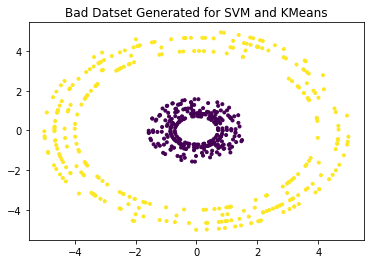

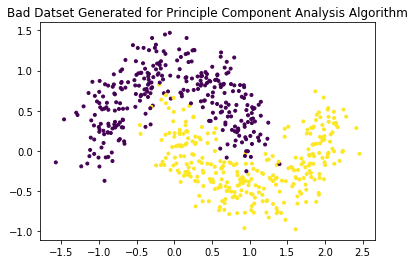

In [6]:
## BAD Dataset for SVM and KMeans
BAD_Data = np.zeros((600,2))
for i in range(0, 300, 30): 
    theta = np.random.randint(low=0, high=628, size=30)/100
    r = np.random.randint(0,14)/7
    BAD_Data[i:i+30,0], BAD_Data[i:i+30,1] = r*np.cos(theta), r*np.sin(theta)

for i in range(300, 600, 30): 
    theta = np.random.randint(low=0, high=628, size=30)/100
    r = np.random.randint(12,16)/3
    BAD_Data[i:i+30,0], BAD_Data[i:i+30,1] = r*np.cos(theta), r*np.sin(theta)

lis = [0 for i in range(0,300)]
lis.extend([1 for i in range(300,600)])
BAD_Data_Y = np.array(lis)

plt.scatter(BAD_Data[:, 0], BAD_Data[:, 1], c = BAD_Data_Y, marker = '.') 
plt.title("Bad Datset Generated for SVM and KMeans")
plt.show()

BAD_svm = BAD_Data
BAD_svm_y = BAD_Data_Y

BAD_kmeans = BAD_svm
BAD_kmeans_Y = BAD_svm_y

## BAD Dataset for PCA
X, Y = make_moons(n_samples = 600, noise = 0.2, random_state=10)
plt.scatter(X[:, 0], X[:, 1], c = Y, marker = '.') 
plt.title("Bad Datset Generated for Principle Component Analysis Algorithm")
plt.show()
BAD_pca = X
BAD_pca_Y = Y


**Exercise 2: Evaluating the "badness" of the data mining methods.**

Write a script that uses the BAD data sets in Exercise 1, runs the corresponding data mining method, produces the output of the method, and evaluates the performance of the method using (e.g., 10-fold) cross-validation and various performance metrics (e.g., variance, precision, recall, F1 measure). Note that not all metrics can be equally applied to every method. Report the performance metrics used and a summary of the results obtained. Reading the chapter “Performance Metrics for Graph Mining Tasks” by Kanchana Padmanabhan and John Jenkins in the resources for performance metrics is strongly encouraged for performing this exercise. 

In [7]:
def RepPerf(cv_results, model):
    print("\n")
    print("Performance Metrics Found out using {} after 10-fold CV are: ".format(model))
    print("..............................................................................................")
    flag_print = True
    for key in cv_results.keys():
        if key == "fit_time" or key == "score_time":
            continue
        print("Avg {} score for the {} is: {} ({})".format(" ".join(key.split("_")), model, np.average(cv_results[key]), key.split("_")[0]))

def kmeans_performance(y, y_pred, show=False):
    mat = confusion_matrix(y, y_pred)
    if mat[0,0]+mat[1,1] < mat[0,1]+mat[1,0]:
        temp1 = mat[0,0]
        temp2 = mat[1,1]
        mat[0,0] = mat[0,1]
        mat[1,1] = mat[1,0]
        mat[0,1] = temp1
        mat[1,0] = temp2
    tp = mat[0,0]
    fp = mat[0,1]
    tn = mat[1,1]
    fn = mat[1,0]
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1 = 2*precision*recall/(precision+recall)
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    if show:
        print("Precision and Recall are equal to {} and {} respectively:".format(precision, recall))
        print("F1 Score is equal to {}".format(f1))
    return (precision, recall, f1, accuracy)
     
### Linear SVM:
model_svm = SVC(C=1.0, kernel='linear')
scoring = ('f1','precision','recall','roc_auc')
cv_results = cross_validate(model_svm, BAD_svm, BAD_svm_y, scoring=scoring, cv=10, return_train_score=True)
RepPerf(cv_results, 'Linear SVM')
model_svm.fit(BAD_svm, BAD_svm_y)
print("Number of support Vectors for both the classes when used with Linear kernel is {}".format(model_svm.n_support_))

### PCA:
kf = KFold(n_splits=10)
explained_variance = []
for train_index, test_index in kf.split(BAD_pca):
    model_pca = PCA(n_components=2)
    X_train = BAD_pca[train_index]
    model_pca.fit_transform(X_train)
    explained_variance.append(model_pca.explained_variance_ratio_[0])
#explained_variance.append(model_pca.fit(BAD_pca).explained_variance_[0])
print("\n")
print("Average Variance Explained after computing PCA to each train component of 10-fold CV are: ")
print("..............................................................................................")
print(mean(explained_variance))


### Kmeans
kf = KFold(n_splits=10)
train_metrics = {'precision':[], 'recall':[], 'f1':[], 'accuracy':[]}
test_metrics = {'precision':[], 'recall':[], 'f1':[], 'accuracy':[]}
for train_index, test_index in kf.split(BAD_kmeans):
    model_kmeans = KMeans(n_clusters=2)
    X_train, y_train = BAD_kmeans[train_index], BAD_kmeans_Y[train_index]
    X_test, y_test = BAD_kmeans[test_index], BAD_kmeans_Y[test_index]
    y_train_pred = model_kmeans.fit_predict(X_train)
    y_test_pred = model_kmeans.fit_predict(X_test)
    (p, r, f, a) = kmeans_performance(y_train, y_train_pred)
    train_metrics['precision'].append(p)
    train_metrics['recall'].append(r)
    train_metrics['f1'].append(f)
    train_metrics['accuracy'].append(a)
    (p, r, f, a) = kmeans_performance(y_test, y_test_pred)
    if math.isnan(f):
        continue
    test_metrics['precision'].append(p)
    test_metrics['recall'].append(r)
    test_metrics['f1'].append(f)
    test_metrics['accuracy'].append(a)

print("\n")
print("Performance Metrics Found out using {} after 10-fold CV are: ".format('KMeans'))
print("..............................................................................................")
print("train sets")
for key, value in train_metrics.items():
    print("{}: {} ".format(key, round(mean(value),2), 'train'), end=" ")
print("\n")
print("test sets")
for key, value in test_metrics.items(): 
    print("{}: {}".format(key, round(mean(value),2), 'test'), end=" ")
        



Performance Metrics Found out using Linear SVM after 10-fold CV are: 
..............................................................................................
Avg test f1 score for the Linear SVM is: 0.5527344022861758 (test)
Avg train f1 score for the Linear SVM is: 0.5780825708983859 (train)
Avg test precision score for the Linear SVM is: 1.0 (test)
Avg train precision score for the Linear SVM is: 0.9968 (train)
Avg test recall score for the Linear SVM is: 0.39 (test)
Avg train recall score for the Linear SVM is: 0.40740740740740744 (train)
Avg test roc auc score for the Linear SVM is: 0.5345555555555556 (test)
Avg train roc auc score for the Linear SVM is: 0.5624362139917696 (train)
Number of support Vectors for both the classes when used with Linear kernel is [283 283]


Average Variance Explained after computing PCA to each train component of 10-fold CV are: 
..............................................................................................
0.7993995101835334



**Exercise 3: Kernelizing the methods.**

Write a script that uses the kernelized version of each of the data mining methods in Exercise 2.
1. Choose at least two kernels for each method.
2. Use the same performance metrics as in Exercise 2 and compare the performance of the original un-kernelized version of the method versus the performance obtained after applying the kernel trick.
3. Do you observe a difference in performance when you use different kernels?
4. What are the best performance results you obtain by trying different kernels and kernel parameters? Also, make sure to report the number of support vectors for the SVM (a good rule of thumb is to strive for no more than 35%-50% support vectors to avoid model overfitting).

In [32]:
def kernel_PCA_select(X, kernel):
    model_pca = KernelPCA(n_components=2, kernel=kernel)
    X_new = model_pca.fit_transform(X)
    return X_new[:,0:2]

def Cross_Val_Test_Kernel_KMeans(X, y, kernel='rbf'):
    X_new = kernel_PCA_select(X, kernel=kernel)
    kf = KFold(n_splits=10)
    train_metrics = {'precision':[], 'recall':[], 'f1':[], 'accuracy':[]}
    test_metrics = {'precision':[], 'recall':[], 'f1':[], 'accuracy':[]}
    for train_index, test_index in kf.split(X_new):
        model_kmeans = KMeans(n_clusters=2)
        X_train, y_train = X_new[train_index], y[train_index]
        X_test, y_test = X_new[test_index], y[test_index]
        y_train_pred = model_kmeans.fit_predict(X_train)
        y_test_pred = model_kmeans.fit_predict(X_test)
        (p, r, f, a) = kmeans_performance(y_train, y_train_pred)
        train_metrics['precision'].append(p)
        train_metrics['recall'].append(r)
        train_metrics['f1'].append(f)
        train_metrics['accuracy'].append(a)
        (p, r, f, a) = kmeans_performance(y_test, y_test_pred)
        if math.isnan(f):
            continue
        test_metrics['precision'].append(p)
        test_metrics['recall'].append(r)
        test_metrics['f1'].append(f)
        test_metrics['accuracy'].append(a)
    print("\n")
    print("Performance Metrics Found out using {} with {} after 10-fold CV are: ".format('Kernel KMeans',kernel))
    print("..............................................................................................")
    print("train")
    for key, value in train_metrics.items():
        print("{}: {}".format(key, round(mean(value),2)), end=" ")
    print("\n")
    print("test")
    for key, value in test_metrics.items():
        print("{}: {}".format(key, round(mean(value),2)), end=" ")
    return None

def Cross_Val_Test_Kernel_PCA(X, kernel):
    kf = KFold(n_splits=10)
    explained_variance = []
    for train_index, test_index in kf.split(X):
        model_pca = KernelPCA(n_components=2, kernel=kernel)
        X_train = X[train_index]
        X_new = model_pca.fit_transform(X_train)
        explained_variance.append(model_pca.lambdas_[0]/np.sum(model_pca.lambdas_))
        #explained_variance.append(np.var(X_new, axis=0)[0])
    #explained_variance.append(model_pca.fit(BAD_pca).explained_variance_[0])
    print("\n")
    print("Average Variance Explained after computing Kernel PCA using {} to each train component of 10-fold CV are:".format(kernel))
    print("..............................................................................................")
    print(mean(explained_variance))
    return None

In [33]:
#########   SVM
## RBF Kernel
model_svm = SVC(C=1, kernel='rbf')
scoring = ('f1','precision','recall','roc_auc')
cv_results = cross_validate(model_svm, BAD_svm, BAD_svm_y, scoring=scoring, cv=10, return_train_score=True)
RepPerf(cv_results, 'SVM with rbf kernel')
model_svm.fit(BAD_svm, BAD_svm_y)
print("\n")
print("Number of support Vectors for both the classes when used with RBF kernel is {}".format(model_svm.n_support_))

## Poly Kernel
model_svm = SVC(C=1.0, kernel='sigmoid')
scoring = ('f1','precision','recall','roc_auc')
cv_results = cross_validate(model_svm, BAD_svm, BAD_svm_y, scoring=scoring, cv=10, return_train_score=True)
RepPerf(cv_results, 'SVM with Polynomial Kernel')
model_svm.fit(BAD_svm, BAD_svm_y)
print("\n")
print("Number of support Vectors for both the classes when used with Sigmoid kernel is {}".format(model_svm.n_support_))

########## PCA
## RBF Kernel 
Cross_Val_Test_Kernel_PCA(BAD_pca, kernel='rbf')

## Sigmoid Kernel
Cross_Val_Test_Kernel_PCA(BAD_pca, kernel='poly')


########## KMeans
### Data Kernelized using RBF
Cross_Val_Test_Kernel_KMeans(BAD_kmeans, BAD_kmeans_Y, kernel='rbf')

### Data Kernelized using Polynomial Kernel
Cross_Val_Test_Kernel_KMeans(BAD_kmeans, BAD_kmeans_Y, kernel='poly')




Performance Metrics Found out using SVM with rbf kernel after 10-fold CV are: 
..............................................................................................
Avg test f1 score for the SVM with rbf kernel is: 1.0 (test)
Avg train f1 score for the SVM with rbf kernel is: 1.0 (train)
Avg test precision score for the SVM with rbf kernel is: 1.0 (test)
Avg train precision score for the SVM with rbf kernel is: 1.0 (train)
Avg test recall score for the SVM with rbf kernel is: 1.0 (test)
Avg train recall score for the SVM with rbf kernel is: 1.0 (train)
Avg test roc auc score for the SVM with rbf kernel is: 1.0 (test)
Avg train roc auc score for the SVM with rbf kernel is: 1.0 (train)


Number of support Vectors for both the classes when used with RBF kernel is [17 78]


Performance Metrics Found out using SVM with Polynomial Kernel after 10-fold CV are: 
..............................................................................................
Avg test f1 score for the S

1. Yes, Performance difference was observed after Kernalization. 
2. Before Kernelization, SVM recieved a f1-score of 0.55 with number of support vectors being nearly 50%. After Kernelization but after Kernelization with RBF, the f1-score rose to 1.0 and support vectors are around 10%.
3. Improved explained variance i.e. around 4% was seen in the case of PCA after kernalization using polynomial kernel.
4. Accuracy and F1-score of KMeans Clustering rose to around 0.70-0.80 after kernelization with polynomial kernel which was previously 0.50-0.60. (These metrics are calculated by comparing predicted cluster labels with ground truth cluster labels) 
5. For applying Kernelization trick to KMeans, these steps were followed: First Kernel PCA is used to kernelize the data but keeping the dimensions same i.e (d==2) and then KMeans was applied.

**Exercise 4: Pipelining.**

Dimension reduction is often used as a key data pre-processing step for other data mining methods downstream the end-to-end data analysis. In this exercise, you will use unsupervised kernel PCA as a pre-processing step for clustering. Later in the course, we will use supervised dimension reduction methods as a pre-processing step for supervised classification methods.
1. Generalize your BAD_kmeans data set to very high-dimensional space (d>>2).
2. Show that the k-means clustering algorithm does not perform well on that data.
3. Apply the kernel PCA method to this high dimensional data set and identify the number (m<<d) of principal components (i.e., eigenvectors) that provide a reasonably good low-dimensional approximation of your data (i.e., based on eigenvalue distribution). How much total variability of the data will be preserved upon using this low-dimensional representation?
4. Project your original data onto the top m eigenvectors corresponding to the largest eigenvalues.
5. Run the k-means clustering algorithm on the projected low dimensional data.
6. Compare the performance of the k-means clustering algorithm on the d-dimensional original data vs. the m-dimensional projected data. Has the performance improved?
7. If you run the kernel k-means clustering algorithm on the original data, will you get better or worse performance? Discuss the pros and cons of using kernel k-means on the original data directly versus applying kernel PCA as a pre-processing step and then running the k-means clustering algorithm on the low-dimensional data.



...........................................................................................
Performance Metrics for the KMeans algorithm  on Generalized high dimensional space are: 
Precision: 0.48333333333333334, Recall: 0.5291970802919708, f1: score 0.5052264808362369, accuracy: 0.5266666666666666


4 principle components out of 26 have been identified by Kernel PCA
Total Variability Preserved is 0.9999999999999722


...........................................................................................
Performance Metrics for the KMeans algorithm on high dim data treated with with kernel PCA are: 
Precision: 0.98, Recall: 0.7050359712230215, f1: score 0.8200836820083681, accuracy: 0.785


...........................................................................................
Performance Metrics for the Kernel KMeans algorithm on high dim data: 
Precision: 1.0, Recall: 0.5033557046979866, f1: score 0.6696428571428572, accuracy: 0.5066666666666667


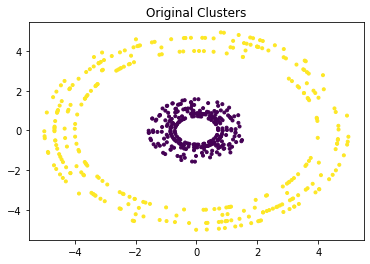

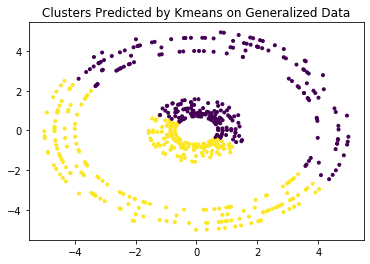

Precision: 0.48333333333333334, Recall: 0.5291970802919708, f1: score 0.5052264808362369, accuracy: 0.5266666666666666


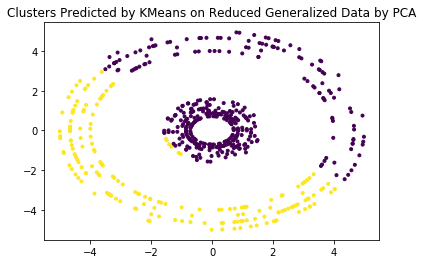

Precision: 0.98, Recall: 0.7050359712230215, f1: score 0.8200836820083681, accuracy: 0.785


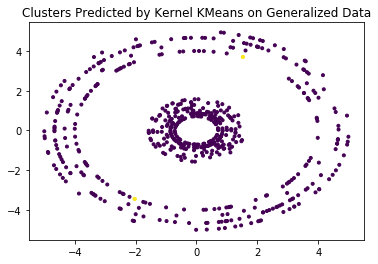

Precision: 1.0, Recall: 0.5033557046979866, f1: score 0.6696428571428572, accuracy: 0.5066666666666667


In [29]:
def kernel_PCA_select(X, n_components, kernel):
    model_pca = KernelPCA(n_components=n_components, kernel=kernel)
    X_new = model_pca.fit_transform(X)
    Total_var = np.sum(model_pca.lambdas_)
    for i in range(0, n_components):
        if np.sum(model_pca.lambdas_[0:i])/Total_var > 0.99:
            break
    print("\n")
    print("{} principle components out of {} have been identified by Kernel PCA".format(i, n_components))
    print("Total Variability Preserved is {}".format(np.sum(model_pca.lambdas_[0:i])/Total_var))
    return X_new[:,0:i]

def Generalize_Data(X, const_one=1.13424, const_two=22.4, const_three=4324255.004, const_four=0.242):
    New_X = np.zeros((X.shape[0],2+24))
    New_X[:,0:2] = X
    count = 2
    for i in [const_one, const_two, const_three, const_four,  0]:
        for j in [const_one, const_two, const_three, const_four, 0]:
            if i==0 and j==0:
                continue
            N = i*X[:,0]+j*X[:,1]
            New_X[:, count] = N
            count = count+1
    return New_X

BAD_kmeans_new = Generalize_Data(BAD_kmeans)

## KMeans on this dataset
### Kmeans
model_kmeans = KMeans(n_clusters=2)
scoring = ('f1', 'normalized_mutual_info_score')
Y_pred_1 = model_kmeans.fit_predict(normalize(BAD_kmeans_new))
(p, r, f, a) = kmeans_performance(BAD_kmeans_Y, Y_pred_1)
print("\n")
print("...........................................................................................")
print("Performance Metrics for the KMeans algorithm  on Generalized high dimensional space are: ")
print("Precision: {}, Recall: {}, f1: score {}, accuracy: {}".format(p, r, f, a))

### Principle Component Selection/ Dimensionality Reduction using PCA:
BAD_kmeans_reduced_dim = kernel_PCA_select(BAD_kmeans_new, BAD_kmeans_new.shape[1], kernel='poly')

### Running Kmeans on reduced dimensional space
model_kmeans = KMeans(n_clusters=2)
scoring = ('f1', 'normalized_mutual_info_score')
Y_pred_2 = model_kmeans.fit_predict(normalize(BAD_kmeans_reduced_dim))
(p, r, f, a) = kmeans_performance(BAD_kmeans_Y, Y_pred_2)
print("\n")
print("...........................................................................................")
print("Performance Metrics for the KMeans algorithm on high dim data treated with with kernel PCA are: ")
print("Precision: {}, Recall: {}, f1: score {}, accuracy: {}".format(p, r, f, a))

## Kernel K-Means on Generalized_Data:
Kernel_Kmeans = SpectralClustering(n_clusters=2, affinity='rbf', gamma=200)
Y_pred_3 = Kernel_Kmeans.fit_predict(BAD_kmeans_new)
(p, r, f, a) = kmeans_performance(BAD_kmeans_Y, Y_pred_3)
print("\n")
print("...........................................................................................")
print("Performance Metrics for the Kernel KMeans algorithm on high dim data: ")
print("Precision: {}, Recall: {}, f1: score {}, accuracy: {}".format(p, r, f, a))


## Plots for Visual Aid
plt.scatter(BAD_kmeans[:, 0], BAD_kmeans[:, 1], c = BAD_kmeans_Y, marker = '.') 
plt.title("Original Clusters")
plt.show()

plt.scatter(BAD_kmeans[:, 0], BAD_kmeans[:, 1], c = Y_pred_1, marker = '.') 
plt.title("Clusters Predicted by Kmeans on Generalized Data")
plt.show()
(p, r, f, a) = kmeans_performance(BAD_kmeans_Y, Y_pred_1)
print("Precision: {}, Recall: {}, f1: score {}, accuracy: {}".format(p, r, f, a))

plt.scatter(BAD_kmeans[:, 0], BAD_kmeans[:, 1], c = Y_pred_2, marker = '.') 
plt.title("Clusters Predicted by KMeans on Reduced Generalized Data by PCA")
plt.show()
(p, r, f, a) = kmeans_performance(BAD_kmeans_Y, Y_pred_2)
print("Precision: {}, Recall: {}, f1: score {}, accuracy: {}".format(p, r, f, a))

plt.scatter(BAD_kmeans[:, 0], BAD_kmeans[:, 1], c = Y_pred_3, marker = '.') 
plt.title("Clusters Predicted by Kernel KMeans on Generalized Data")
plt.show()
(p, r, f, a) = kmeans_performance(BAD_kmeans_Y, Y_pred_3)
print("Precision: {}, Recall: {}, f1: score {}, accuracy: {}".format(p, r, f, a))

Question 6.
Yes, The acuuracy and F1-score were improved almost 10%. Refer to the performance in the Exercise 4 (Kernel KMeans) to compare the performance. 

Question 7.
Applying Kernel Kmeans on Generalized data gave equal or towards bad performance than non-pca treated normal-Kmeans algorithm. The yellow dots might have mixed with blue and may not be visible in the last diagram. But the f1-score is decent i.e. 0.66. However, Applying PCA before KMeans leads the Race over other two approaches. i.e. has accuracy and f-scores greater than the other two appraoches and also consistent because precision and recall have a decent average, i.e. none of them are biased towards less as in other two approaches.
